## Importing Libraries

In [ ]:
! pip install gensim --quiet

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import os
sys.path.append('/content/drive/MyDrive/quora_duplicate_questions/src')

import joblib
import re

import numpy as np
import pandas as pd

from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import (cosine_similarity,
                                      euclidean_distances,
                                      manhattan_distances)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import gensim.downloader as api

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

from tqdm.auto import tqdm
tqdm.pandas()

from utils import evaluate_model, plot_confusion_matrix

## Load data

In [29]:
DATA_PATH = '/content/drive/MyDrive/quora_duplicate_questions/data/processed'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv.zip'), compression='zip')
val_df = pd.read_csv(os.path.join(DATA_PATH, 'val.csv.zip'), compression='zip')

## Preprocess text

In [3]:
def preprocess_text(text):
    """Clean and preprocess text"""
    if pd.isna(text):
        return []

    # Convert to lowercase
    text = str(text).lower()

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    stop_words = set(stopwords.words('english'))

    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stop_words]

    return tokens

In [4]:
print("Preprocessing questions for Train set...")
train_df['q1_tokens'] = train_df['question1'].progress_apply(preprocess_text)
train_df['q2_tokens'] = train_df['question2'].progress_apply(preprocess_text)

Preprocessing questions for Train set...


  0%|          | 0/258743 [00:00<?, ?it/s]

  0%|          | 0/258743 [00:00<?, ?it/s]

In [5]:
print("Preprocessing questions for Validation set...")
val_df['q1_tokens'] = val_df['question1'].progress_apply(preprocess_text)
val_df['q2_tokens'] = val_df['question2'].progress_apply(preprocess_text)

Preprocessing questions for Validation set...


  0%|          | 0/64686 [00:00<?, ?it/s]

  0%|          | 0/64686 [00:00<?, ?it/s]

## Load GloVe Embeddings

In [8]:
glove_name='glove-wiki-gigaword-100'

glove_model = api.load(glove_name)
print(f"GloVe model loaded successfully. Vocabulary size: {len(glove_model)}")
print(f"Embedding dimension: {glove_model.vector_size}")

[==================================================] 100.0% 128.1/128.1MB downloaded
GloVe model loaded successfully. Vocabulary size: 400000
Embedding dimension: 100


In [9]:
def get_sentence_embedding(tokens, model):
    """Get sentence embedding by averaging word embeddings"""
    if not tokens:
      return np.zeros(model.vector_size)

    embeddings = []
    for token in tokens:
        if token in model:
            embeddings.append(model[token])

    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
      return np.zeros(model.vector_size)

## Prepare text features

In [10]:
def create_features(df, model):
    """Create features using embeddings"""
    features = []

    for idx, row in df.iterrows():
        if idx % 10000 == 0:
            print(f"Precessing row {idx}/{len(df)}")

        # Get embeddings for each question
        q1_emb = get_sentence_embedding(row['q1_tokens'], model)
        q2_emb = get_sentence_embedding(row['q2_tokens'], model)

        # Create similarity features
        cos_sim = cosine_similarity(q1_emb.reshape(1, -1), q2_emb.reshape(1, -1))[0][0]
        euclidean_dist = euclidean_distances(q1_emb.reshape(1, -1),
                                             q2_emb.reshape(1, -1))[0][0]
        manhattan_dist = manhattan_distances(q1_emb.reshape(1, -1),
                                             q2_emb.reshape(1, -1))[0][0]

        # Element-wise features
        diff = q1_emb - q2_emb
        mult = q1_emb * q2_emb

        # Combine features
        feature_vector = np.concatenate([
            q1_emb, q2_emb, diff, mult, [cos_sim], [euclidean_dist], [manhattan_dist]
        ])
        features.append(feature_vector)

    return np.array(features)

In [69]:
print("Create features for Train set:")
X_train_features = create_features(train_df, glove_model)

print("\nCreate features for Validation set:")
X_val_features = create_features(val_df, glove_model)

Create features for Train set:
Precessing row 0/258743
Precessing row 10000/258743
Precessing row 20000/258743
Precessing row 30000/258743
Precessing row 40000/258743
Precessing row 50000/258743
Precessing row 60000/258743
Precessing row 70000/258743
Precessing row 80000/258743
Precessing row 90000/258743
Precessing row 100000/258743
Precessing row 110000/258743
Precessing row 120000/258743
Precessing row 130000/258743
Precessing row 140000/258743
Precessing row 150000/258743
Precessing row 160000/258743
Precessing row 170000/258743
Precessing row 180000/258743
Precessing row 190000/258743
Precessing row 200000/258743
Precessing row 210000/258743
Precessing row 220000/258743
Precessing row 230000/258743
Precessing row 240000/258743
Precessing row 250000/258743

Create features for Validation set:
Precessing row 0/64686
Precessing row 10000/64686
Precessing row 20000/64686
Precessing row 30000/64686
Precessing row 40000/64686
Precessing row 50000/64686
Precessing row 60000/64686


## Train and Evaluate Logistic Regression

In [83]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_val_scaled = scaler.transform(X_val_features)

In [84]:
y_train = train_df['is_duplicate']
y_val = val_df['is_duplicate']

In [85]:
classifier = LogisticRegression(random_state=7, class_weight='balanced', max_iter=1000)
classifier.fit(X_train_scaled, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=7)

In [91]:
log_loss_train, log_loss_val = evaluate_model(
    X_train_scaled, X_val_scaled, y_train, y_val, classifier
)
print(f"Log loss on Train set: {log_loss_train:.4f}")
print(f"Log loss on Validation set: {log_loss_val:.4f}")

Log loss on Train set: 0.5662
Log loss on Validation set: 0.5654


Classification Report:
               precision    recall  f1-score   support

Not Duplicate       0.83      0.67      0.74     40804
    Duplicate       0.58      0.76      0.65     23882

     accuracy                           0.70     64686
    macro avg       0.70      0.72      0.70     64686
 weighted avg       0.73      0.70      0.71     64686



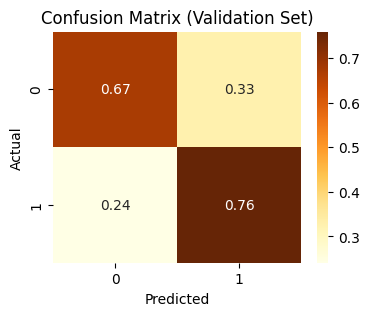

In [ ]:
print(f"Classification Report:")
y_pred = classifier.predict(X_val_scaled)
print(classification_report(y_val, y_pred,
                            target_names=['Not Duplicate', 'Duplicate']))


plot_confusion_matrix(y_val, y_pred)

In [90]:
experiment_results = joblib.load(os.path.join(DATA_PATH, 'experiment_results.joblib'))

In [93]:
results = {}
results['model'] = 'GloVe Embeddings with Logistic Regression'
results['log_loss_train'] = np.round(log_loss_train, 5)
results['log_loss_val'] = np.round(log_loss_val, 5)

experiment_results.append(results)

In [94]:
joblib.dump(experiment_results, os.path.join(DATA_PATH, 'experiment_results.joblib'))

['/content/drive/MyDrive/quora_duplicate_questions/data/processed/experiment_results.joblib']

`experiment_results` is updated and saved with the latest experiment's metrics.